In [1]:
from diffusers import DiffusionPipeline
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipeline = DiffusionPipeline.from_pretrained(
    'lansinuote/diffsion_from_scratch.params', safety_checker=None)

scheduler = pipeline.scheduler
tokenizer = pipeline.tokenizer

del pipeline

device, scheduler, tokenizer

d:\anaconda\envs\torchkan\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\anaconda\envs\torchkan\lib\site-packages\transformers\utils\hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
unet\diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]An error occurred while trying to fetch D:\huggingface\hub\models--lansinuote--diffsion_from_scratch.params\snapshots\310d9345e14b3b625635041dd573676c008d83ea\vae: Error no file named diffusion_pytorch_model.safetensors found in directory D:\huggingface\hub\models--lansinuote--diffsion_from_scratch.params\snapshots\310d9345e14b3b625635041dd573676c008d83ea\vae.
Defaulting to unsafe serialization. Pass `allow_pickle

('cuda',
 PNDMScheduler {
   "_class_name": "PNDMScheduler",
   "_diffusers_version": "0.30.3",
   "beta_end": 0.012,
   "beta_schedule": "scaled_linear",
   "beta_start": 0.00085,
   "clip_sample": false,
   "num_train_timesteps": 1000,
   "prediction_type": "epsilon",
   "set_alpha_to_one": false,
   "skip_prk_steps": true,
   "steps_offset": 1,
   "timestep_spacing": "leading",
   "trained_betas": null
 },
 CLIPTokenizer(name_or_path='D:\huggingface\hub\models--lansinuote--diffsion_from_scratch.params\snapshots\310d9345e14b3b625635041dd573676c008d83ea\tokenizer', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
 	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
 	49407:

In [2]:
from openl3model import OpenL3Embedding
import numpy as np
import torch
import audiocore
import audio_utils as au
import warnings
import core

encoder = OpenL3Embedding(input_repr='mel256', embedding_size=512, content_type="music")



d:\pycbj\数字信号处理作业\Diffusion_From_Scratch-main\timefreq.py:93: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_filters = librosa.filters.mel(sr=self.sr, n_fft=self.n_fft, n_mels=n_mels, fmin=self.fmin, fmax=self.fmax, htk=self.htk) # (mel, 1+n_fft/2)


In [3]:
from vae_main import VAE
from diffusers import AutoencoderKL

#加载预训练模型的参数
params = AutoencoderKL.from_pretrained(
    'lansinuote/diffsion_from_scratch.params', subfolder='vae')

vae = VAE()


def load_res(model, param):
    model.s[0].load_state_dict(param.norm1.state_dict())
    model.s[2].load_state_dict(param.conv1.state_dict())
    model.s[3].load_state_dict(param.norm2.state_dict())
    model.s[5].load_state_dict(param.conv2.state_dict())

    if isinstance(model.res, torch.nn.Module):
        model.res.load_state_dict(param.conv_shortcut.state_dict())

'''def load_custom_state_dict(model, state_dict):
    # 手动映射参数名称
    new_state_dict = {}
    for k, v in state_dict.items():
        if k == '0.weight':
            new_state_dict['out.weight'] = v
        elif k == '0.bias':
            new_state_dict['out.bias'] = v
        else:
            new_state_dict[k] = v

    # 加载状态字典
    model.load_state_dict(new_state_dict, strict=False)'''
def load_atten(model, param):
    model.norm.load_state_dict(param.group_norm.state_dict())
    model.q.load_state_dict(param.to_q.state_dict())
    model.k.load_state_dict(param.to_k.state_dict())
    model.v.load_state_dict(param.to_v.state_dict())
    model.out.load_state_dict(param.to_out.state_dict())


#encoder.in
vae.encoder[0].load_state_dict(params.encoder.conv_in.state_dict())

#encoder.down
for i in range(4):
    load_res(vae.encoder[i + 1][0], params.encoder.down_blocks[i].resnets[0])
    load_res(vae.encoder[i + 1][1], params.encoder.down_blocks[i].resnets[1])

    if i != 3:
        vae.encoder[i + 1][2][1].load_state_dict(
            params.encoder.down_blocks[i].downsamplers[0].conv.state_dict())

#encoder.mid
load_res(vae.encoder[5][0], params.encoder.mid_block.resnets[0])
load_res(vae.encoder[5][2], params.encoder.mid_block.resnets[1])
load_atten(vae.encoder[5][1], params.encoder.mid_block.attentions[0])

#encoder.out
vae.encoder[6][0].load_state_dict(params.encoder.conv_norm_out.state_dict())
vae.encoder[6][2].load_state_dict(params.encoder.conv_out.state_dict())

#encoder.正态分布层
vae.encoder[7].load_state_dict(params.quant_conv.state_dict())

#decoder.正态分布层
vae.decoder[0].load_state_dict(params.post_quant_conv.state_dict())

#decoder.in
vae.decoder[1].load_state_dict(params.decoder.conv_in.state_dict())

#decoder.mid
load_res(vae.decoder[2][0], params.decoder.mid_block.resnets[0])
load_res(vae.decoder[2][2], params.decoder.mid_block.resnets[1])
load_atten(vae.decoder[2][1], params.decoder.mid_block.attentions[0])

#decoder.up
for i in range(4):
    load_res(vae.decoder[i + 3][0], params.decoder.up_blocks[i].resnets[0])
    load_res(vae.decoder[i + 3][1], params.decoder.up_blocks[i].resnets[1])
    load_res(vae.decoder[i + 3][2], params.decoder.up_blocks[i].resnets[2])

    if i != 3:
        vae.decoder[i + 3][4].load_state_dict(
            params.decoder.up_blocks[i].upsamplers[0].conv.state_dict())

#decoder.out
vae.decoder[7][0].load_state_dict(params.decoder.conv_norm_out.state_dict())
vae.decoder[7][2].load_state_dict(params.decoder.conv_out.state_dict())
from vae_main import VAE
from diffusers import AutoencoderKL

#加载预训练模型的参数
params = AutoencoderKL.from_pretrained(
    'lansinuote/diffsion_from_scratch.params', subfolder='vae')

vae = VAE()


def load_res(model, param):
    model.s[0].load_state_dict(param.norm1.state_dict())
    model.s[2].load_state_dict(param.conv1.state_dict())
    model.s[3].load_state_dict(param.norm2.state_dict())
    model.s[5].load_state_dict(param.conv2.state_dict())

    if isinstance(model.res, torch.nn.Module):
        model.res.load_state_dict(param.conv_shortcut.state_dict())

'''def load_custom_state_dict(model, state_dict):
    # 手动映射参数名称
    new_state_dict = {}
    for k, v in state_dict.items():
        if k == '0.weight':
            new_state_dict['out.weight'] = v
        elif k == '0.bias':
            new_state_dict['out.bias'] = v
        else:
            new_state_dict[k] = v

    # 加载状态字典
    model.load_state_dict(new_state_dict, strict=False)'''
def load_atten(model, param):
    model.norm.load_state_dict(param.group_norm.state_dict())
    model.q.load_state_dict(param.to_q.state_dict())
    model.k.load_state_dict(param.to_k.state_dict())
    model.v.load_state_dict(param.to_v.state_dict())
    model.out.load_state_dict(param.to_out.state_dict())


#encoder.in
vae.encoder[0].load_state_dict(params.encoder.conv_in.state_dict())

#encoder.down
for i in range(4):
    load_res(vae.encoder[i + 1][0], params.encoder.down_blocks[i].resnets[0])
    load_res(vae.encoder[i + 1][1], params.encoder.down_blocks[i].resnets[1])

    if i != 3:
        vae.encoder[i + 1][2][1].load_state_dict(
            params.encoder.down_blocks[i].downsamplers[0].conv.state_dict())

#encoder.mid
load_res(vae.encoder[5][0], params.encoder.mid_block.resnets[0])
load_res(vae.encoder[5][2], params.encoder.mid_block.resnets[1])
load_atten(vae.encoder[5][1], params.encoder.mid_block.attentions[0])

#encoder.out
vae.encoder[6][0].load_state_dict(params.encoder.conv_norm_out.state_dict())
vae.encoder[6][2].load_state_dict(params.encoder.conv_out.state_dict())

#encoder.正态分布层
vae.encoder[7].load_state_dict(params.quant_conv.state_dict())

#decoder.正态分布层
vae.decoder[0].load_state_dict(params.post_quant_conv.state_dict())

#decoder.in
vae.decoder[1].load_state_dict(params.decoder.conv_in.state_dict())

#decoder.mid
load_res(vae.decoder[2][0], params.decoder.mid_block.resnets[0])
load_res(vae.decoder[2][2], params.decoder.mid_block.resnets[1])
load_atten(vae.decoder[2][1], params.decoder.mid_block.attentions[0])

#decoder.up
for i in range(4):
    load_res(vae.decoder[i + 3][0], params.decoder.up_blocks[i].resnets[0])
    load_res(vae.decoder[i + 3][1], params.decoder.up_blocks[i].resnets[1])
    load_res(vae.decoder[i + 3][2], params.decoder.up_blocks[i].resnets[2])

    if i != 3:
        vae.decoder[i + 3][4].load_state_dict(
            params.decoder.up_blocks[i].upsamplers[0].conv.state_dict())

#decoder.out
vae.decoder[7][0].load_state_dict(params.decoder.conv_norm_out.state_dict())
vae.decoder[7][2].load_state_dict(params.decoder.conv_out.state_dict())

An error occurred while trying to fetch lansinuote/diffsion_from_scratch.params: lansinuote/diffsion_from_scratch.params does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch lansinuote/diffsion_from_scratch.params: lansinuote/diffsion_from_scratch.params does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


<All keys matched successfully>

In [4]:
from unet_main import UNet

unet=UNet()
unet=torch.load('unet.pth')
encoder.to(device)
vae.to(device)
unet.to(device)

encoder.eval()
vae.eval()
unet.eval()

UNet(
  (in_vae): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (in_time): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_block0): DownBlock(
    (tf0): Transformer(
      (norm_in): GroupNorm(32, 320, eps=1e-06, affine=True)
      (cnn_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
      (norm_atten0): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (atten1): CrossAttention(
        (q): Linear(in_features=320, out_features=320, bias=False)
        (k): Linear(in_features=320, out_features=320, bias=False)
        (v): Linear(in_features=320, out_features=320, bias=False)
        (out): Linear(in_features=320, out_features=320, bias=True)
      )
      (norm_atten1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (atten2): CrossAttention(
        (q): Linear(in_features=320, out_features=320, bias=False)
      

tensor(981, device='cuda:0')
tensor(961, device='cuda:0')
tensor(961, device='cuda:0')
tensor(941, device='cuda:0')
tensor(921, device='cuda:0')
tensor(901, device='cuda:0')
tensor(881, device='cuda:0')
tensor(861, device='cuda:0')
tensor(841, device='cuda:0')
tensor(821, device='cuda:0')
tensor(801, device='cuda:0')
tensor(781, device='cuda:0')
tensor(761, device='cuda:0')
tensor(741, device='cuda:0')
tensor(721, device='cuda:0')
tensor(701, device='cuda:0')
tensor(681, device='cuda:0')
tensor(661, device='cuda:0')
tensor(641, device='cuda:0')
tensor(621, device='cuda:0')
tensor(601, device='cuda:0')
tensor(581, device='cuda:0')
tensor(561, device='cuda:0')
tensor(541, device='cuda:0')
tensor(521, device='cuda:0')
tensor(501, device='cuda:0')
tensor(481, device='cuda:0')
tensor(461, device='cuda:0')
tensor(441, device='cuda:0')
tensor(421, device='cuda:0')
tensor(401, device='cuda:0')
tensor(381, device='cuda:0')
tensor(361, device='cuda:0')
tensor(341, device='cuda:0')
tensor(321, de

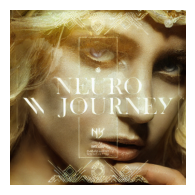

In [9]:
hop_size=1
from matplotlib import pyplot as plt
@torch.no_grad()

def generate(audio):
    #词编码
    #[1, 77]
    audiocore._check_audio_types(audio)
    if audiocore._is_zero(audio):
        warnings.warn(f'provided audio array is all zeros')
    audio = audiocore.downmix(audio)

    # split audio into overlapping windows as dictated by hop_size
    hop_len: int = hop_size * core.SAMPLE_RATE
    audio = audiocore.window(audio, window_len=hop_size*core.SAMPLE_RATE, hop_len=hop_len)
    index=np.arange(0,audio.shape[0])
    r_index=np.random.choice(index,30)
    audio_sample=audio[r_index]
    # convert to torch tensor!
    audio = torch.from_numpy(np.array(audio_sample))
    audio = audio.to(device)
    #[1, 77, 768]
    pos = encoder(audio).unsqueeze(0)
    neg = encoder(audio).unsqueeze(0)
    
    #[1+1, 77, 768] -> [2, 77, 768]
    out_encoder = torch.cat((neg, pos), dim=0)

    #vae的压缩图,从随机噪声开始
    out_vae = torch.randn(1, 4, 64, 64, device=device)

    #生成50个时间步,一般是从980-0
    scheduler.set_timesteps(50, device=device)
    for time in scheduler.timesteps:
        print(time)
        #往图中加噪音
        #[1+1, 4, 64, 64] -> [2, 4, 64, 64]
        noise = torch.cat((out_vae, out_vae), dim=0)
        noise = scheduler.scale_model_input(noise, time)

        #计算噪音
        #[2, 4, 64, 64],[2, 77, 768],scala -> [2, 4, 64, 64]
        pred_noise = unet(out_vae=noise, out_encoder=out_encoder, time=time)

        #从正例图中减去反例图
        #[2, 4, 64, 64] -> [1, 4, 64, 64]
        pred_noise = pred_noise[0] + 7.5 * (pred_noise[1] - pred_noise[0])

        #重新添加噪音,以进行下一步计算
        #[1, 4, 64, 64]
        out_vae = scheduler.step(pred_noise, time, out_vae).prev_sample

    #从压缩图恢复成图片
    out_vae = 1 / 0.18215 * out_vae
    #[1, 4, 64, 64] -> [1, 3, 512, 512]
    image = vae.decoder(out_vae)

    #转换成图片数据
    image = image.cpu()
    image = (image + 1) / 2
    image = image.clamp(0, 1)
    image = image.permute(0, 2, 3, 1)
    return image.numpy()[0]

audios=au.load_audio_file("C:/Users/Lenovo/Desktop/The Singing Swan-Fractal Dreamers/The Singing Swan-Fractal Dreamers.flac")
image=generate(audios)


plt.figure(figsize=(10, 5))
plt.subplot(2, 3, i + 1)
plt.imshow(image)
plt.axis('off')
plt.show()


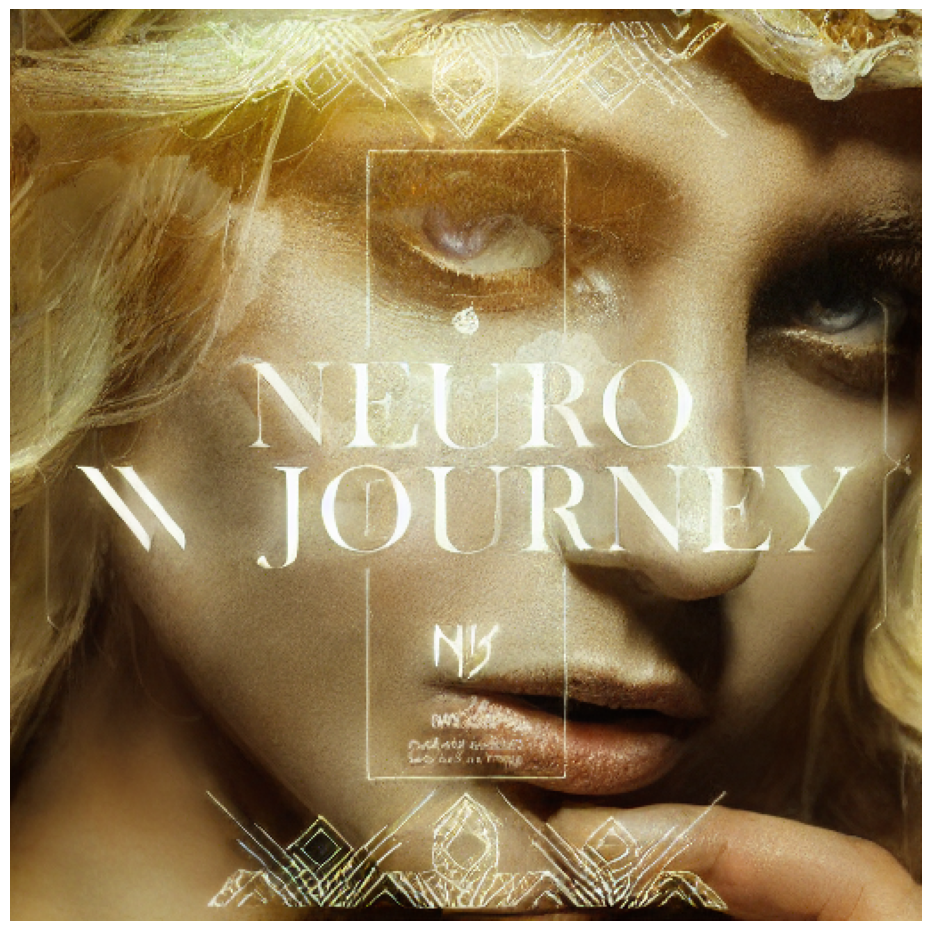

In [10]:
plt.figure(figsize=(40, 40))
plt.subplot(2, 3, i + 1)
plt.imshow(image)
plt.axis('off')
plt.show()
